# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para Proyecto](#path)
- [3 - Análisis de Datos Exploratorios (EDA)](#eda)
- [4 - Metadata](#meta)
    - [4.1 - División de metadata en train/valid](#carga_train_valid)
    - [4.2 - División de metadata en test](#carga_test)
- [6 - Carga de metadata procesada](#carga_datos)
- [7 - Creación de DataBlock](#db)
    - [7.1 - Creación del dataset](#ds)
    - [7.2 - División del dataloader en train/valid](#train-valid)
    - [7.3 - División del dataloader en test](#test)
- [8 - Cantidad de etiquetas](#etiquetas)
- [9 - Cantidad de datos en cada uno de los grupos: train/valid/test](#train-valid-test)
- [10 - Función de Accuracy: ATSIA_ACC](#acc_atsia)
- [11 - Función de Pérdida: Binary Cross-Entropy with Logits Loss](#loss_fun)
- [12 - Entrenamiento de Modelo](#model)
- [13 - Pregressive Resizing](#presizing)
- [14 - Métricas/Resutados](#metrics)
- [15 - Widget Prueba](#widget)

<a name='lib'></a>
## Librerías

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from utils_ATSIA import *
import os
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [2]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestinos", "Uropodos"]
grados = ["G0", "G1", "G2", "G3", "G4"]
caracteristicas = {"AmpollaRectal" :["GG", "N"], #"Gregarinas Gametocistos, Nemátodos"
                   "Branquias" : ["S", "M", "N", "P", "AF"],# "Suciedad, Melanización, Necrosis, Protozoarios y Algas Filamentosas"
                   "Hepatopancreas" : ["DC", "DT", "L", "M", "N"], #"Deformidad Celular, Desprendimiento Tubular, Lípidos, Melanización y Necrosis"
                   "Intestinos" : ["GT", "GG", "N", "A", "RC"], #"Gregarinas Trofozoito, Gregarina Gametocistos, Nemátodos, Algas y Restos de Crustaceos"
                   "Uropodos" : ["Prem", "Muda", "Post", "Inte"]}

#Necesitamos la cantidad de caracteres que cada etiqueta tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 26, "Intestinos" : 27, "Uropodos" :4}

In [3]:
main_path = Path(os.getcwd())
Path.BASE_PATH = main_path
path = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos:
    path["img"][organo] = Path(main_path, "img", organo)
    path["metadata"][organo] = Path(main_path, "metadata", organo)

<a name='eda'></a>
## Análisis Exploratorio de Datos (EDA)

In [4]:
count = get_img_count(organos, organo_len, caracteristicas, grados, path)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 201.78it/s]


No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/AmpollaRectal
No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/Branquias


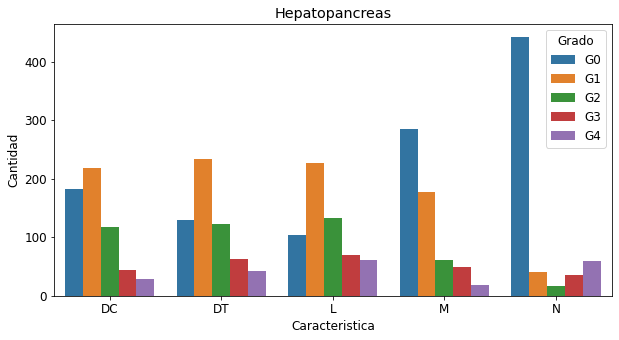

No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/Intestinos
No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/Uropodos


In [5]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        hepato=data
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Caracteristica", y = "Cantidad", hue = "Grado")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")

No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/AmpollaRectal
No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/Branquias


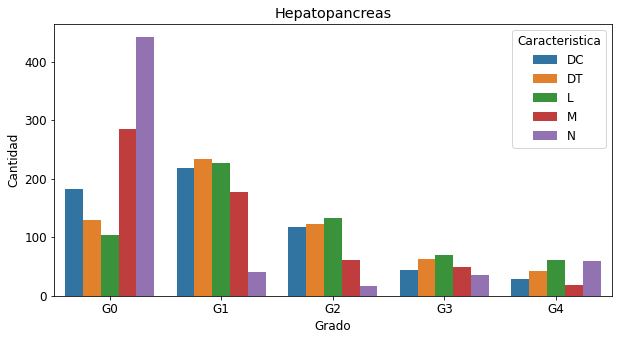

No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/Intestinos
No hay imágenes en la carpeta /home/ubuntu/ATSIA/img/Uropodos


In [6]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Grado", y = "Cantidad", hue = "Caracteristica")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")


<a name='meta'></a>
## Metadata

In [7]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [8]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = Path(path["metadata"][organo], f"metadata_{organo}.csv"), index=False)
metadata

img_name                      labels
0         DT_G3-DC_G0-L_G4-M_G0-N_G0.png  DT_G3 DC_G0 L_G4 M_G0 N_G0
1     DT_G2-DC_G0-L_G2-M_G1-N_G1 (2).png  DT_G2 DC_G0 L_G2 M_G1 N_G1
2     DT_G4-DC_G2-L_G4-M_G3-N_G4 (7).png  DT_G4 DC_G2 L_G4 M_G3 N_G4
3     DT_G1-DC_G4-L_G2-M_G4-N_G1 (2).png  DT_G1 DC_G4 L_G2 M_G4 N_G1
4    DT_G1-DC_G0-L_G1-M_G0-N_G0 (13).png  DT_G1 DC_G0 L_G1 M_G0 N_G0
..                                   ...                         ...
587       DT_G0-DC_G1-L_G3-M_G0-N_G2.png  DT_G0 DC_G1 L_G3 M_G0 N_G2
588   DT_G0-DC_G0-L_G1-M_G0-N_G0 (9).png  DT_G0 DC_G0 L_G1 M_G0 N_G0
589       DT_G2-DC_G1-L_G3-M_G2-N_G3.png  DT_G2 DC_G1 L_G3 M_G2 N_G3
590   DT_G1-DC_G2-L_G1-M_G2-N_G0 (2).png  DT_G1 DC_G2 L_G1 M_G2 N_G0
591       DT_G3-DC_G1-L_G1-M_G1-N_G0.png  DT_G3 DC_G1 L_G1 M_G1 N_G0

[592 rows x 2 columns]

<a name='carga_train_valid'></a> 
### División de metadata en train/valid 

In [9]:
metadata_train_valid = pd.read_csv(Path(path["metadata"][organo], f"metadata_{organo}.csv"), sep = ",").sample(frac=0.90, random_state = 42)
metadata_train_valid.to_csv(path_or_buf = Path(path["metadata"][organo], f"metadata_{organo}_train_valid.csv"), index=False)
metadata_train_valid.sample(5)

img_name                      labels
530   DT_G2-DC_G1-L_G1-M_G0-N_G0 (8).png  DT_G2 DC_G1 L_G1 M_G0 N_G0
32   DT_G0-DC_G0-L_G1-M_G0-N_G0 (11).png  DT_G0 DC_G0 L_G1 M_G0 N_G0
274   DT_G1-DC_G0-L_G0-M_G1-N_G0 (2).png  DT_G1 DC_G0 L_G0 M_G1 N_G0
406   DT_G0-DC_G0-L_G0-M_G0-N_G0 (4).png  DT_G0 DC_G0 L_G0 M_G0 N_G0
527  DT_G0-DC_G0-L_G2-M_G0-N_G0 (11).png  DT_G0 DC_G0 L_G2 M_G0 N_G0

<a name='carga_test'></a> 
### División de metadata en test

In [10]:
metadata_test_no_final = pd.read_csv(Path(path["metadata"][organo], f"metadata_{organo}.csv"), sep = ",").drop(metadata_train_valid.index)
metadata_test_no_final.to_csv(path_or_buf = Path(path["metadata"][organo], f"metadata_{organo}_test_no_final.csv"), index=False)
metadata_test_no_final.sample(5)

img_name                      labels
491   DT_G0-DC_G0-L_G3-M_G0-N_G0 (2).png  DT_G0 DC_G0 L_G3 M_G0 N_G0
454   DT_G1-DC_G1-L_G1-M_G1-N_G0 (3).png  DT_G1 DC_G1 L_G1 M_G1 N_G0
1     DT_G2-DC_G0-L_G2-M_G1-N_G1 (2).png  DT_G2 DC_G0 L_G2 M_G1 N_G1
80   DT_G1-DC_G1-L_G0-M_G0-N_G0 (20).png  DT_G1 DC_G1 L_G0 M_G0 N_G0
58        DT_G1-DC_G1-L_G1-M_G0-N_G4.png  DT_G1 DC_G1 L_G1 M_G0 N_G4

<a name='carga_datos'></a> 
## Carga de metadata procesada

In [11]:
metadata_train_valid = pd.read_csv(Path(path["metadata"][organo], f"metadata_{organo}_train_valid.csv"), sep = ",")
metadata_train_valid.sample(5)

img_name                      labels
123      DT_G4-DC_G2-L_G2-M_G0-N_G0.png  DT_G4 DC_G2 L_G2 M_G0 N_G0
170      DT_G1-DC_G1-L_G1-M_G1-N_G2.png  DT_G1 DC_G1 L_G1 M_G1 N_G2
87   DT_G2-DC_G1-L_G3-M_G1-N_G0 (2).png  DT_G2 DC_G1 L_G3 M_G1 N_G0
138      DT_G3-DC_G2-L_G3-M_G0-N_G3.png  DT_G3 DC_G2 L_G3 M_G0 N_G3
134  DT_G3-DC_G2-L_G1-M_G0-N_G0 (2).png  DT_G3 DC_G2 L_G1 M_G0 N_G0

In [12]:
metadata_test = pd.read_csv(Path(path["metadata"][organo], f"metadata_{organo}_test.csv"), sep = ";")
metadata_test.sample(5)

img_name                      labels  is_valid
48  DT_G1-DC_G0-L_G0-M_G0-N_G0 (3).png  DT_G1 DC_G0 L_G0 M_G0 N_G0         1
15  DT_G2-DC_G1-L_G2-M_G1-N_G0 (4).png  DT_G2 DC_G1 L_G2 M_G1 N_G0         1
38  DT_G4-DC_G1-L_G3-M_G0-N_G0 (2).png  DT_G4 DC_G1 L_G3 M_G0 N_G0         1
54  DT_G0-DC_G0-L_G0-M_G1-N_G0 (7).png  DT_G0 DC_G0 L_G0 M_G1 N_G0         1
52  DT_G1-DC_G1-L_G1-M_G1-N_G0 (9).png  DT_G1 DC_G1 L_G1 M_G1 N_G0         1

<a name='db'></a> 
## Creación de DataBlock

In [13]:
def get_x(r): return Path(path["img"][organo], r['img_name'])
def get_y(r): return r['labels'].split(" ")
    
def get_data(presize, resize, test = False):
    if test == False:
        return DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                         get_x = get_x, 
                         get_y = get_y, 
                         item_tfms = Resize(presize, method='crop', pad_mode='zeros'),
                         splitter = RandomSplitter(valid_pct=0.15, seed=42),
                         batch_tfms =[*aug_transforms(size = resize,
                                                      mult=1.0,
                                                      do_flip=True,
                                                      flip_vert=True,
                                                      max_rotate=10.0, 
                                                      min_zoom=1.0, 
                                                      max_zoom=1.2,   
                                                      mode='bilinear', 
                                                      pad_mode='zeros',  
                                                      min_scale=0.75),Normalize.from_stats(*imagenet_stats)]
                        )
    else: 
        return DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                         get_x = get_x, 
                         get_y = get_y, 
                         item_tfms = Resize(presize, method='crop', pad_mode='zeros'), 
                         splitter = ColSplitter(col = "is_valid"),
                        )

In [14]:
dblock = get_data(500, 250, test = False)

<a name='ds'></a> 
### Creación del Dataset

In [15]:
dsets = dblock.datasets(metadata_train_valid)
dsets.train[0]

(PILImage mode=RGB size=840x840,
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [16]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#5) ['DC_G1','DT_G4','L_G2','M_G0','N_G0']

<a name='train-valid'></a> 
### División del dataloader en train/valid

In [17]:
dls = dblock.dataloaders(metadata_train_valid, bs=16)

<a name='test'></a> 
### División del dataloader en test

In [18]:
dblock_test = get_data(500, 250, test = True)

In [19]:
dls_test = dblock_test.dataloaders(metadata_test, bs=16)

<a name='etiquetas'></a> 
## Cantidad de etiquetas

In [20]:
print(len(dls.vocab))
labels = dls.vocab
print(labels)

25
['DC_G0', 'DC_G1', 'DC_G2', 'DC_G3', 'DC_G4', 'DT_G0', 'DT_G1', 'DT_G2', 'DT_G3', 'DT_G4', 'L_G0', 'L_G1', 'L_G2', 'L_G3', 'L_G4', 'M_G0', 'M_G1', 'M_G2', 'M_G3', 'M_G4', 'N_G0', 'N_G1', 'N_G2', 'N_G3', 'N_G4']


<a name='train-valid-test'></a> 
## Cantidad de datos en cada uno de los grupos: train/valid/test

### Train

In [21]:
len(dls.train.items)

454

In [22]:
dls.train.items

img_name                      labels
314       DT_G4-DC_G1-L_G2-M_G0-N_G0.png  DT_G4 DC_G1 L_G2 M_G0 N_G0
302   DT_G1-DC_G0-L_G1-M_G0-N_G0 (5).png  DT_G1 DC_G0 L_G1 M_G0 N_G0
376  DT_G1-DC_G1-L_G0-M_G0-N_G0 (26).png  DT_G1 DC_G1 L_G0 M_G0 N_G0
24   DT_G0-DC_G0-L_G1-M_G0-N_G0 (16).png  DT_G0 DC_G0 L_G1 M_G0 N_G0
50   DT_G0-DC_G0-L_G0-M_G0-N_G0 (14).png  DT_G0 DC_G0 L_G0 M_G0 N_G0
..                                   ...                         ...
188  DT_G1-DC_G1-L_G0-M_G0-N_G0 (25).png  DT_G1 DC_G1 L_G0 M_G0 N_G0
319   DT_G1-DC_G1-L_G2-M_G2-N_G3 (2).png  DT_G1 DC_G1 L_G2 M_G2 N_G3
340   DT_G0-DC_G0-L_G0-M_G0-N_G0 (6).png  DT_G0 DC_G0 L_G0 M_G0 N_G0
320   DT_G0-DC_G0-L_G0-M_G0-N_G0 (8).png  DT_G0 DC_G0 L_G0 M_G0 N_G0
495   DT_G1-DC_G1-L_G1-M_G1-N_G0 (5).png  DT_G1 DC_G1 L_G1 M_G1 N_G0

[454 rows x 2 columns]

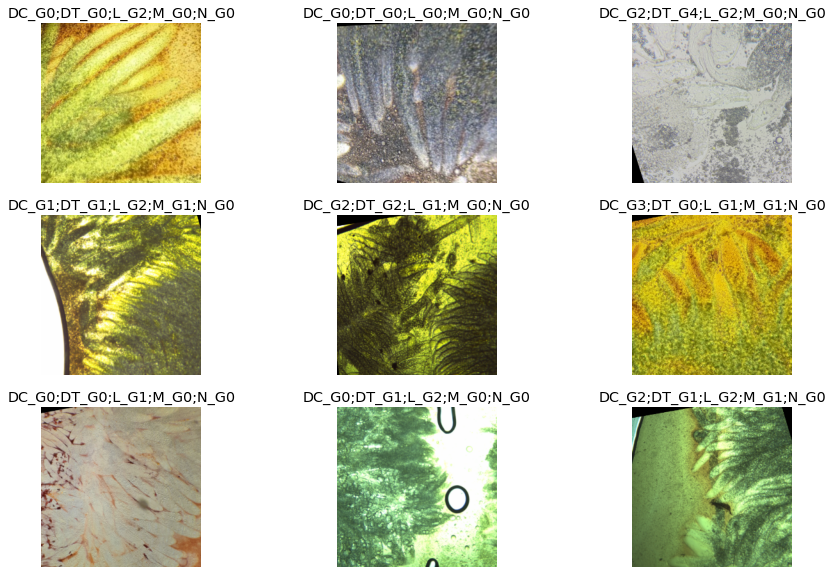

In [23]:
dls.train.show_batch(nrows=3, ncols=3, figsize=(15,10))

### Valid

In [24]:
len(dls.valid.items)

79

In [25]:
dls.valid.items

img_name                      labels
369   DT_G1-DC_G0-L_G1-M_G0-N_G0 (8).png  DT_G1 DC_G0 L_G1 M_G0 N_G0
52        DT_G0-DC_G0-L_G4-M_G2-N_G0.png  DT_G0 DC_G0 L_G4 M_G2 N_G0
423       DT_G2-DC_G1-L_G2-M_G1-N_G1.png  DT_G2 DC_G1 L_G2 M_G1 N_G1
357   DT_G2-DC_G2-L_G1-M_G1-N_G0 (7).png  DT_G2 DC_G2 L_G1 M_G1 N_G0
181   DT_G0-DC_G0-L_G0-M_G0-N_G0 (2).png  DT_G0 DC_G0 L_G0 M_G0 N_G0
..                                   ...                         ...
162   DT_G2-DC_G1-L_G0-M_G0-N_G0 (3).png  DT_G2 DC_G1 L_G0 M_G0 N_G0
190  DT_G0-DC_G0-L_G1-M_G0-N_G0 (14).png  DT_G0 DC_G0 L_G1 M_G0 N_G0
408   DT_G4-DC_G4-L_G4-M_G4-N_G4 (4).png  DT_G4 DC_G4 L_G4 M_G4 N_G4
432   DT_G0-DC_G1-L_G0-M_G1-N_G0 (2).png  DT_G0 DC_G1 L_G0 M_G1 N_G0
266       DT_G0-DC_G2-L_G2-M_G3-N_G1.png  DT_G0 DC_G2 L_G2 M_G3 N_G1

[79 rows x 2 columns]

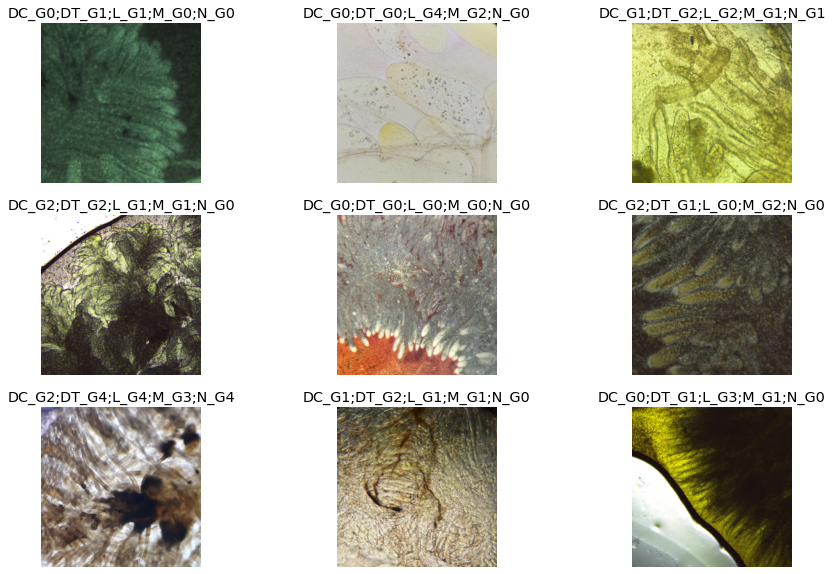

In [26]:
dls.valid.show_batch(nrows=3, ncols=3, figsize=(15,10))

### Test

In [27]:
len(dls_test.valid.items)

51

In [ ]:
dls_test.valid.items

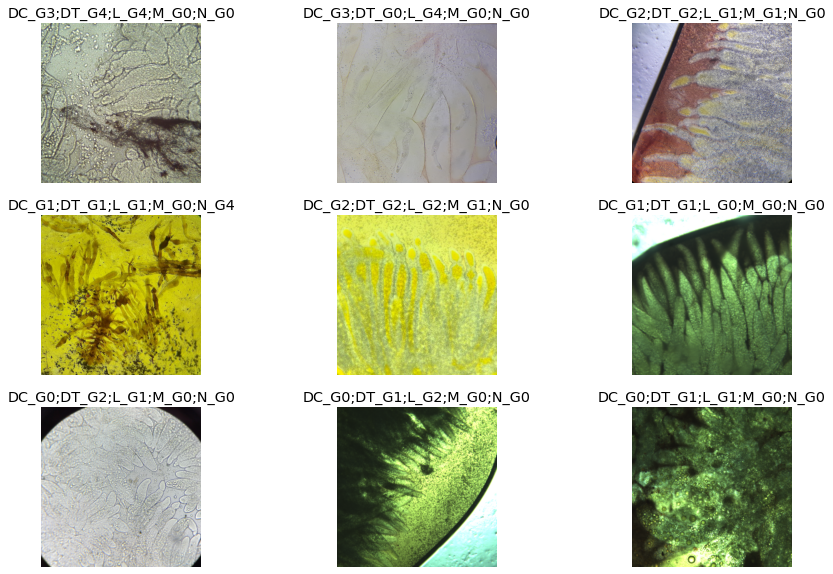

In [29]:
dls_test.valid.show_batch(nrows=3, ncols=3, figsize=(15,10))

<a name='acc_atsia'></a> 
## Función de Accuracy: accuracy_multi_atsia

In [30]:
def get_info():
    return organo, caracteristicas, grados

def accuracy_multi_atsia(y_preds, y):
    y_preds = y_preds.sigmoid()    
    
    organo, caracteristicas, grados = get_info()
    columns =[]
    for caracteristica in caracteristicas[organo]:
        columns.append(f"ACC_{caracteristica}")
    #Al final columns vendrá en la forma columns = ["ACC_DC", "ACC_DT", "ACC_L", "ACC_M", "ACC_N"] para Hepatopancreas

    acc = pd.DataFrame(np.zeros((len(y_preds), len(columns))), columns = columns)

    for i in range(0, len(y_preds)):
        for j, caracteristica in enumerate(caracteristicas[organo]): 
            if j != len(grados)-1:
                preds = y_preds[i][len(grados)*j : len(grados)*(j+1)]
                targs = y[i][len(grados)*j : len(grados)*(j+1)]

            else:
                preds = y_preds[i][len(grados)*j :]
                targs = y[i][len(grados)*j :]

            if torch.eq(preds.argmax(), targs.argmax()):
                acc[f"ACC_{caracteristica}"][i] = 1
                
    #print(len(y_preds), acc.describe().loc["mean"].mean())
    return acc.describe().loc["mean"].mean()

<a name='loss_fun'></a> 
## Función de Pérdida: Binary Cross-Entropy with Logits Loss

In [31]:
class BCEWithLogitsLossFlat_atsia(BaseLoss):
    '''
    * Se modificó la función __init__ para que tenga en consideración las caracteristicas y el 
      organo que se está evaluando.
    *  Se modificó la función decodes para satisfacer las necesidades del proyecto de siempre
      predicir 1 etiqueta (grado) para cada característica, es decir, debe de predecir 
      len(caracteristica[organo]) etiquetas
    '''
    
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, organo, caracteristicas, grados,  **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh
        self.organo = organo
        self.caracteristicas = caracteristicas
        self.grados = grados        
    
    def decodes(self, x):     
        '''Usado para poder obtener los valores más altos de cada caracteristica como 1 y el resto como
        0 para cuando toque hacer el ploteo de learn.show_results(). Entra un tensor con 
        shape = len(caractetisticas[organo] * len(grados) con los valores luego de haber pasado por la 
        sigmoid, se escoge el mayor en intervalos de 5 en 5, dandole el valor de 1 y el resto 0. 
        Ej:
        preds = [0.1, 0.2, 0.3, 0.4, 0.5,         preds_norm = [0, 0, 0, 0, 1,
                 0.6, 0.9, 0.7, 0.1, 0.2]                       0, 1, 0, 0, 0]
        y luego preds_norm se comparará con el ground truth cuando se utilice el método show_results
        de la librería fast.ai'''
        
        preds_norm = np.array(np.zeros(x.shape))   
        for i in range(0, len(x)):
            cat = []
            for j, caracteristica in enumerate(self.caracteristicas[self.organo]): 
                if j != len(self.grados)-1:
                    temp = x[i][len(self.grados)*j : len(self.grados)*(j+1)]
                else:
                    temp = x[i][len(self.grados)*j :]
                    
                temp_new = np.zeros(len(temp))
                temp_new[temp.argmax()] = 1
                cat = np.append(cat, temp_new)
            preds_norm[i] = np.array(cat)

        preds_norm = torch.from_numpy(preds_norm)       
        return preds_norm>self.thresh
    
    def activation(self, x): return torch.sigmoid(x)

<a name='model'></a> 
## Modelo/Resultados

In [32]:
learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = accuracy_multi_atsia,
                    loss_func = BCEWithLogitsLossFlat_atsia(organo = organo, 
                                                            caracteristicas = caracteristicas, 
                                                            grados = grados
                                                           )
                   )

SuggestedLRs(valley=0.001737800776027143)

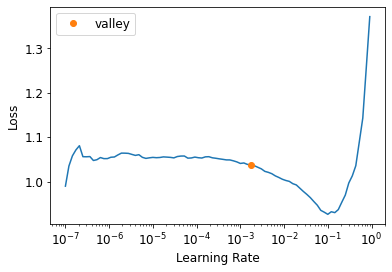

In [33]:
learn.lr_find()

In [34]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(1e-3, 5e-2), cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.4329113924050633.
Better model found at epoch 1 with accuracy_multi_atsia value: 0.4708860759493671.
Better model found at epoch 2 with accuracy_multi_atsia value: 0.4810126582278481.
Better model found at epoch 3 with accuracy_multi_atsia value: 0.5265822784810127.
Better model found at epoch 4 with accuracy_multi_atsia value: 0.5417721518987342.


In [35]:
learn.unfreeze()

SuggestedLRs(valley=0.0002290867705596611)

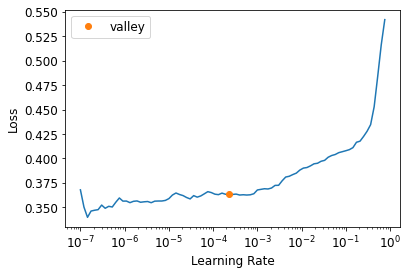

In [36]:
learn.lr_find()

In [37]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(1e-8, 5e-6), cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.5443037974683544.
Better model found at epoch 4 with accuracy_multi_atsia value: 0.5468354430379747.


SuggestedLRs(valley=0.00010964782268274575)

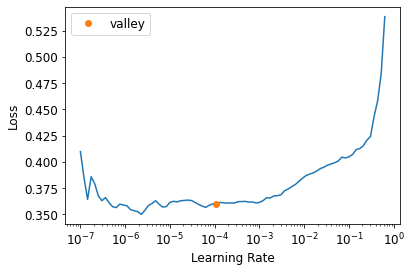

In [38]:
learn.lr_find()

In [39]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]

learn.fine_tune(15, base_lr=1e-6, freeze_epochs = 5, cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.5417721518987342.
Better model found at epoch 2 with accuracy_multi_atsia value: 0.5468354430379746.


Better model found at epoch 0 with accuracy_multi_atsia value: 0.5417721518987342.
Better model found at epoch 4 with accuracy_multi_atsia value: 0.5468354430379746.


<a name='presizing'></a> 
## Pregressive Resizing

In [40]:
dblock = get_data(750, 500)
dls = dblock.dataloaders(metadata, bs=16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = accuracy_multi_atsia,
                    loss_func = BCEWithLogitsLossFlat_atsia(organo = organo, 
                                                            caracteristicas = caracteristicas, 
                                                            grados = grados
                                                           )
                   )

SuggestedLRs(valley=0.001737800776027143)

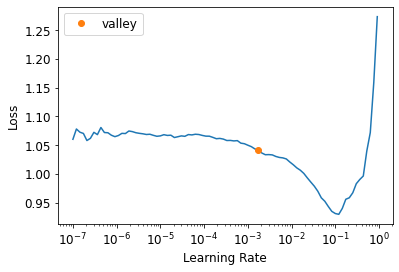

In [41]:
learn.lr_find()

In [42]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(1e-3, 5e-2), cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.475.
Better model found at epoch 1 with accuracy_multi_atsia value: 0.5090909090909091.
Better model found at epoch 2 with accuracy_multi_atsia value: 0.5431818181818181.
Better model found at epoch 3 with accuracy_multi_atsia value: 0.5545454545454546.
Better model found at epoch 4 with accuracy_multi_atsia value: 0.5636363636363636.
Better model found at epoch 6 with accuracy_multi_atsia value: 0.5727272727272728.
Better model found at epoch 8 with accuracy_multi_atsia value: 0.6.


In [43]:
learn.unfreeze()

SuggestedLRs(valley=3.981071586167673e-06)

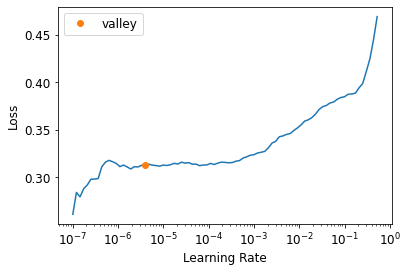

In [44]:
learn.lr_find()

In [45]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(10, lr_max = slice(1e-8, 5e-6), cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.5886363636363637.
Better model found at epoch 3 with accuracy_multi_atsia value: 0.6022727272727273.


SuggestedLRs(valley=9.120108734350652e-05)

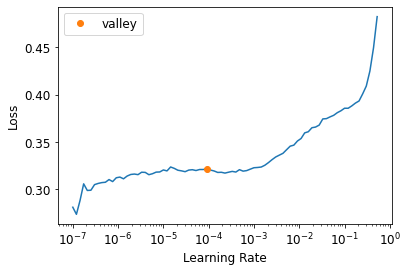

In [46]:
learn.lr_find()

In [47]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]

learn.fine_tune(15, base_lr=5e-3, freeze_epochs = 5, cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.5954545454545455.


Better model found at epoch 0 with accuracy_multi_atsia value: 0.5681818181818181.
Better model found at epoch 2 with accuracy_multi_atsia value: 0.575.
Better model found at epoch 4 with accuracy_multi_atsia value: 0.5863636363636364.


<a name='metrics'></a> 
## Métricas/Resultados

In [48]:
## Ultimo presizing utilizado aplicado al test
dblock_test = get_data(750, 500, test = True)
dls_test = dblock_test.dataloaders(metadata_test, bs = 16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = accuracy_multi_atsia,
                    loss_func = BCEWithLogitsLossFlat_atsia(organo = organo, 
                                                            caracteristicas = caracteristicas, 
                                                            grados = grados
                                                           )
                   )

In [49]:
learn.load("model_test")

In [50]:
learn.metrics = accuracy_multi_atsia
learn.validate(dl = dls_test.valid)

(#2) [0.3707822561264038,0.5568627450980392]

In [52]:
def get_preds_norm(x):
    preds_norm = np.array(np.zeros(x.shape))
    for i in range(0, len(x)):
        cat = []
        for j, caracteristica in enumerate(caracteristicas[organo]): 
            if j != len(grados)-1:
                temp = x[i][len(grados)*j : len(grados)*(j+1)]
            else:
                temp = x[i][len(grados)*j :]

            temp_new = np.zeros(len(temp))
            temp_new[temp.argmax()] = 1
            cat = np.append(cat, temp_new)
        preds_norm[i] = np.array(cat)

    preds_norm = torch.from_numpy(preds_norm)
    
    return preds_norm

In [53]:
preds, targs = learn.get_preds(dl = dls_test.valid)

In [54]:
from sklearn.metrics import multilabel_confusion_matrix
predsnorm = get_preds_norm(preds)
vis_arr = multilabel_confusion_matrix(targs, predsnorm)

In [55]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CFM - " + class_label)

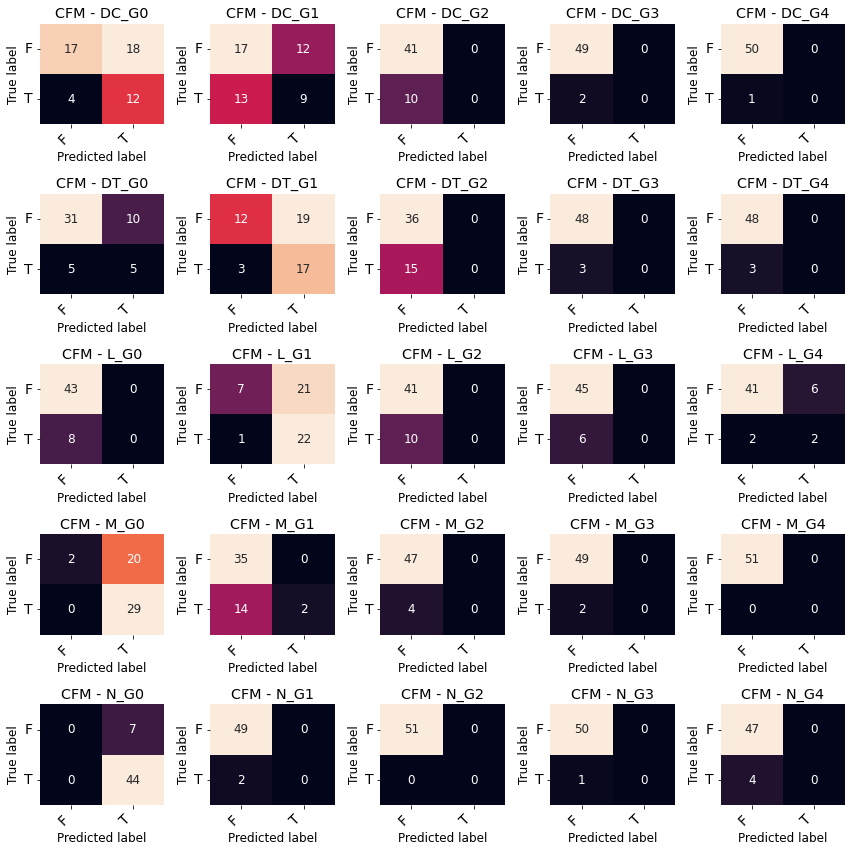

In [56]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
plt.show()

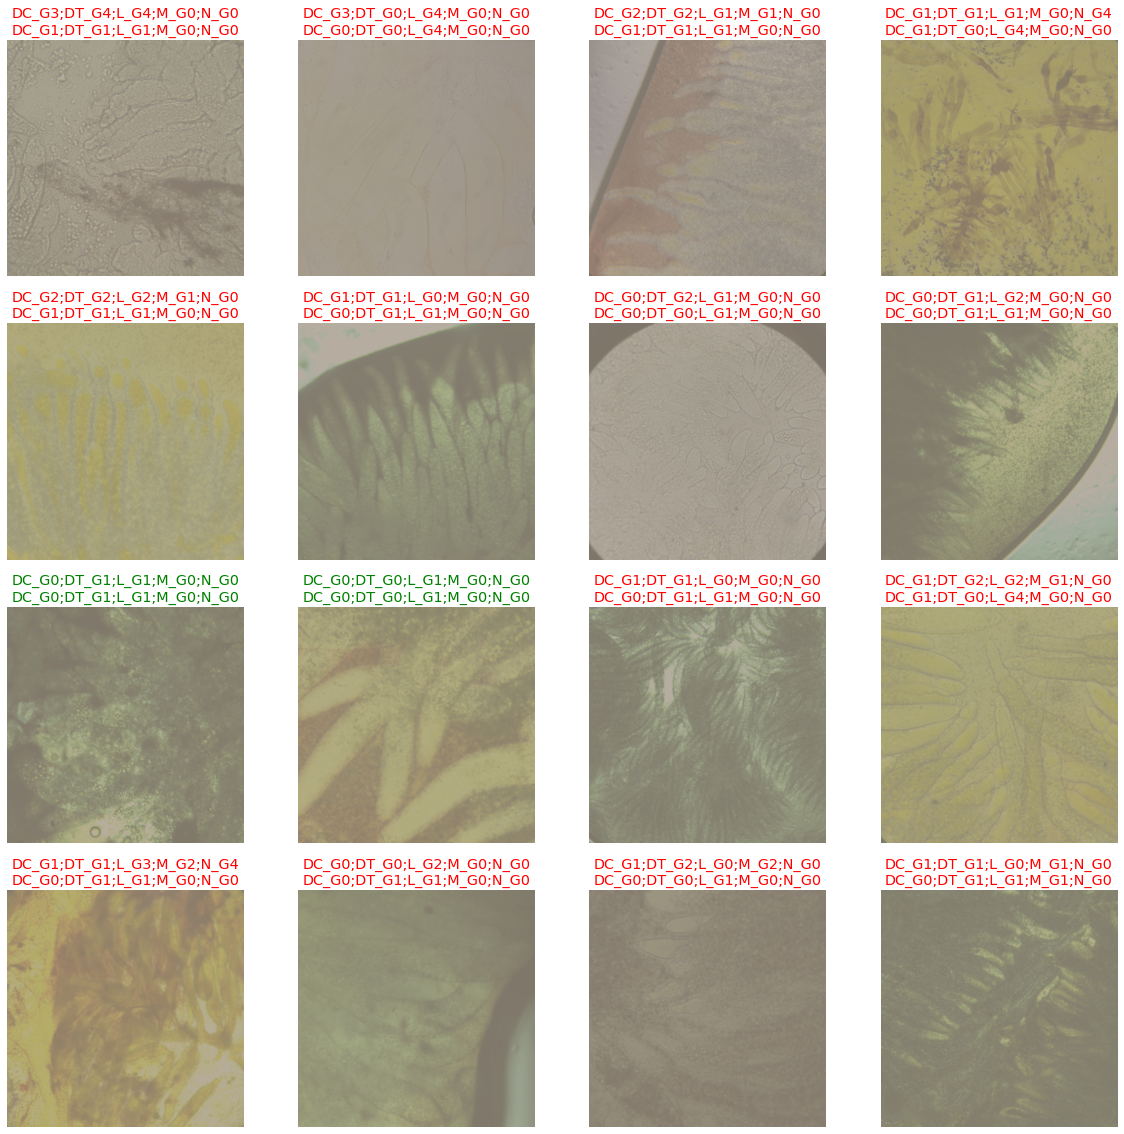

In [57]:
learn.show_results(dl = dls_test.valid, ds_idx = 0, max_n = 16, figsize = (20,20), shuffle=False)

<a name='widget'></a> 
## Widget Test

In [58]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(500,500))
out_pl

In [ ]:
pred,pred_idx,probs = learn.predict(img)
pred